In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/zindidata/SampleSubmission.csv
/kaggle/input/zindidata/Train.csv
/kaggle/input/zindidata/Test.csv
/kaggle/input/zindidata/images/images/ab79912e70d6f5cd30f6cf58c31c9ea9025a210f.jpg
/kaggle/input/zindidata/images/images/66afa71daaa249fbc84d26e0f0d4d1335f7e4040.jpg
/kaggle/input/zindidata/images/images/4419ac5729cffeb5b2e02cbcb8183b2cfe323254.jpg
/kaggle/input/zindidata/images/images/78a69baedd896a2ca96ed0f63fd284b3d8ddbbd1.jpg
/kaggle/input/zindidata/images/images/49010135b36a2ad6e815a7382d1b2d8458dbe8da.jpg
/kaggle/input/zindidata/images/images/837423c8155c5de12394e13aaa020efa6ea12049.jpg
/kaggle/input/zindidata/images/images/8d5781f32f86a728b38bbbd74bcf7aa1187c0a61.jpg
/kaggle/input/zindidata/images/images/e623543fbe025f8a27d04a7938aa6d969dd57dce.jpg
/kaggle/input/zindidata/images/images/b7e0d2b32652fec3607a2cec24d8290026131f53.jpg
/kaggle/input/zindidata/images/images/e06c9ae5fdc29b0c277a376d07e69de6e1dafe11.jpg
/kaggle/input/zindidata/images/images/946b3562450d71121a68

In [2]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor
from torchvision import transforms,datasets
from torch.utils.data import DataLoader

In [3]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, csv_path, images_folder, transform = None):
        self.df = pd.read_csv(csv_path)
        self.images_folder = images_folder
        self.transform = transform
        self.class2index = {"DR":0, "G":1,"ND":2,"WD":3,"other":4}

    def __len__(self):
        return len(self.df)
    def __getitem__(self, index):
        filename = self.df.loc[index, "filename"]
        label = self.class2index[self.df.loc[index, "damage"]]
        image = PIL.Image.open(os.path.join(self.images_folder, filename))
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [4]:
data_transform = transforms.Compose([
    transforms.Resize(size = (224,224)),
    transforms.ToTensor()
])

In [5]:
train_set = CustomDataset(
    csv_path="/kaggle/input/zindidata/Train.csv",
    images_folder="/kaggle/input/zindidata/images/images",
    transform=data_transform,
)
test_set = CustomDataset(
    csv_path = "/kaggle/input/zindidata/Test.csv",
    images_folder ="/kaggle/input/zindidata/images/images",
    transform=data_transform,
)

batch_size =32

# Dataset is actually a lot larger ~25k images, just took out 10 pictures
# to upload to Github. It's enough to understand the structure and scale
# if you got more images.
# train_set, test_set = torch.utils.data.random_split(dataset, [20000, 6068])
train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_set, batch_size=batch_size, shuffle=False)

In [6]:
len(train_loader),len(test_loader)

(815, 271)

In [7]:
import PIL
import matplotlib.pyplot as plt

In [8]:
image_classes = train_set.class2index
image_classes

{'DR': 0, 'G': 1, 'ND': 2, 'WD': 3, 'other': 4}

Image shape: torch.Size([32, 3, 224, 224])
Image classes {'DR': 0, 'G': 1, 'ND': 2, 'WD': 3, 'other': 4}
label 1


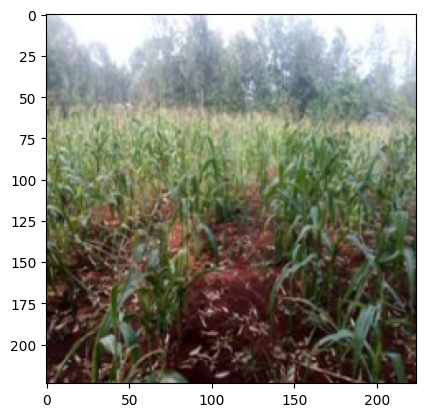

In [9]:
img, label = next(iter(train_loader))
plt.imshow((img[0]).permute(1,2,0))
print(f"Image shape: {img.shape}")
print(f"Image classes {image_classes}")
print(f"label {label[0]}")

In [10]:
from torch import nn

In [11]:
class Model01(nn.Module):
    def __init__(self,input_shape:int,hidden_units:int,output_shape:int):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1 ),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                     out_channels=hidden_units,
                     kernel_size=3,
                     stride=1,
                     padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                     out_channels=hidden_units,
                     kernel_size=3,
                     padding=1,
                     stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                     out_channels=hidden_units,
                     kernel_size=3,
                     padding=1,
                     stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*56*56,
                     out_features=output_shape)
        )

    def forward(self,x):
        x = self.conv_block_1(x)
#         print(f"Output shape for the first conv block {x.shape}")
        x = self.conv_block_2(x)
#         print(f"Output of the second conv block {x.shape}")
        x = self.classifier(x)
#         print(f"Output shape for the classfier conv block {x.shape}")
        return x

In [12]:
len(image_classes)

5

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = Model01(3,20,len(image_classes)).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model.parameters(),lr=0.001)

In [14]:
num_epochs = 9
#  Train Network
for epoch in range(num_epochs):
    losses = []

    for batch_idx, (data, targets) in enumerate(train_loader):
        # Get data to cuda if possible
        data = data.to(device=device)
        targets = targets.to(device=device)

        # forward
        scores = model(data)
        loss = loss_fn(scores, targets)

        losses.append(loss.item())

        # backward
        optimizer.zero_grad()
        loss.backward()

        # gradient descent or adam step
        optimizer.step()

    print(f"Cost at epoch {epoch} is {sum(losses)/len(losses)}")

# Check accuracy on training to see how good our model is
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)

            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)

        print(
            f"Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}"
        )

    model.train()


print("Checking accuracy on Training Set")
check_accuracy(train_loader, model)

print("Checking accuracy on Test Set")
check_accuracy(test_loader, model)

Cost at epoch 0 is 1.1076873520400627
Cost at epoch 1 is 1.0437463162135492
Cost at epoch 2 is 1.0044011745716166
Cost at epoch 3 is 0.9637915192206213
Cost at epoch 4 is 0.9084119172915359
Cost at epoch 5 is 0.8246426413395653
Cost at epoch 6 is 0.7144055989622339
Cost at epoch 7 is 0.6046342098639786
Cost at epoch 8 is 0.5107053354473933
Checking accuracy on Training Set
Got 22096 / 26068 with accuracy 84.76
Checking accuracy on Test Set


KeyError: 'damage'

In [ ]:
from tqdm.auto import tqdm
torch.manual_seed(42)

epochs = 5

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-----")
    train_acc = 0
    for batch, (X,y) in enumerate(train_loader):

        model.train()
        y_pred = model(X)

        loss=loss_fn(y_pred,y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss /= len(train_loader)
        acc  = accuracy_fn(y,y_pred.argmax(dim=1))
        train_acc += acc

        model_1.eval()
        test_ac = 0
        with torch.inference_mode():
            for X_test,y_test in test_dataloader:
                test_pred = model_1(X_test)
                test_loss = loss_fn(test_pred,y_test)
                test_acc = accuracy_fn(y_test,test_pred.argmax(dim=1))
                test_ac += test_acc

            test_ac /= len(test_loader)
        train_acc /= len(train_loader)

    print(f"Train accuracy {train_acc:.4f}| Train loss {loss:.4f}| Test accuracy {test_ac:.4f}| Test Loss {test_loss:.4f}")



In [ ]:
np.sqrt(62720)

In [ ]:
print(train_loader)

# Model
model = torchvision.models.googlenet(weights="DEFAULT")

# freeze all layers, change final linear layer with num_classes
for param in model.parameters():
    param.requires_grad = False

# final layer is not frozen
model.fc = nn.Linear(in_features=1024, out_features=num_classes)
model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

In [ ]:
from tqdm.auto import tqdm
# from torchmetrics import Accuracy

torch.manual_seed(42)
# train_time_start_on_cpu = timer()

epochs = 5

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-----")

    train_loss = 0
#     Add a loop to loop through the training batches
    for batch,(X,y) in enumerate(train_loader):
        model_1.train()

        y_pred = model_1(X)

        loss = loss_fn(y_pred,y)
        train_loss += loss

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        # if batch % 400 == 0:
        #     print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples.")

    train_loss /= len(train_dataloader)

#     Testing
    test_loss, test_acc = 0,0
    model_1.eval()
    with torch.inference_mode():
        for X_test,y_test in test_dataloader:
            test_pred = model_1(X_test)

            test_loss += loss_fn(test_pred,y_test)

            test_acc += accuracy_fn(y_test,test_pred.argmax(dim=1))

            test_loss /= len(test_dataloader)

            test_acc /= len(test_dataloader)

    print(f"\nTrain loss: {train_loss:.4f} | Test loss: {test_loss:.4f}, Test acc: {test_acc :.4f}")

In [ ]:
# Train Network
for epoch in range(num_epochs):
    losses = []

    for batch_idx, (data, targets) in enumerate(train_loader):
        # Get data to cuda if possible
        data = data.to(device=device)
        targets = targets.to(device=device)

        # forward
        scores = model(data)
        loss = criterion(scores, targets)

        losses.append(loss.item())

        # backward
        optimizer.zero_grad()
        loss.backward()

        # gradient descent or adam step
        optimizer.step()

    print(f"Cost at epoch {epoch} is {sum(losses)/len(losses)}")


In [ ]:




# Check accuracy on training to see how good our model is
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)

            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)

        print(
            f"Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}"
        )

    model.train()


print("Checking accuracy on Training Set")
check_accuracy(train_loader, model)

print("Checking accuracy on Test Set")
check_accuracy(test_loader, model)

In [ ]:
from torch.utils.data import DataLoader
BATCH_SIZE = 32
train_dataloader = DataLoader(dataset = train_data,
                             batch_size = BATCH_SIZE,
                             num_workers=os.cpu_count(),
                             shuffle =True)

test_dataloader = DataLoader(dataset = test_data,
                            batch_size = BATCH_SIZE,
                            num_workers=os.cpu_count(),
                            shuffle = False)
